# RIP.ie daily death data (v2)

* rip.ie
* http://dmnfarrell.github.io/
* https://data.gov.ie/dataset/list-of-nursing-homes-in-ireland/resource/489aad00-cad1-41d7-92bf-8b5cdd9d61ea
* https://data.gov.ie/dataset/62954fa3-1492-48af-93d1-5c9bf6a14d1e/resource/142d3b64-8f02-4ed7-bfbd-dc3e20420f3f#&r=C01885V02316&c=STATISTIC


In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates
import difflib, re

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')
pd.set_option('display.max_colwidth', 500)

In [32]:
def get_data(dups=False):
    
    df = pd.read_pickle('rip_dn_scrape_processed.pkl')
    df=df.dropna(subset=['date'])
    if dups==False:
        df=df.drop_duplicates(['name','date','county'])
    print (len(df))    
    df['date'] = pd.to_datetime(df.date,format='%d/%m/%Y',errors='coerce')
    df['name'] = df.name.replace('  ',' ')
    df.index=df.index.astype('int')
    df.sort_index()
    df['year'] = df.date.dt.year.astype(int)
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.dayofyear
    df['week'] = df.date.dt.isocalendar().week
    #df['week'] = df.date.dt.strftime('%W').astype('int')
    df['year-week'] = df.date.dt.strftime('%Y-W%U')
    return df

df = get_data()
df = df[df.year>=2008]

449109


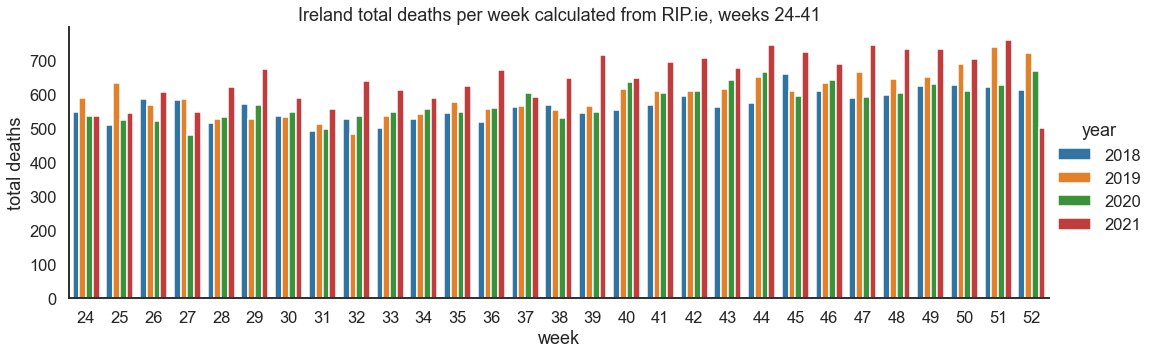

In [33]:
g=df.groupby(['year','week']).agg({'name':np.size}).reset_index()
g=g[(g.week>23) & (g.week<=52)]
g = g[(g.year>2017) & (g.year<2022)]
#print (g)
sns.catplot(data=g,x='week',y='name',hue='year',kind='bar',aspect=3.0)
plt.ylabel('total deaths')
plt.title('Ireland total deaths per week calculated from RIP.ie, weeks 24-41')
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

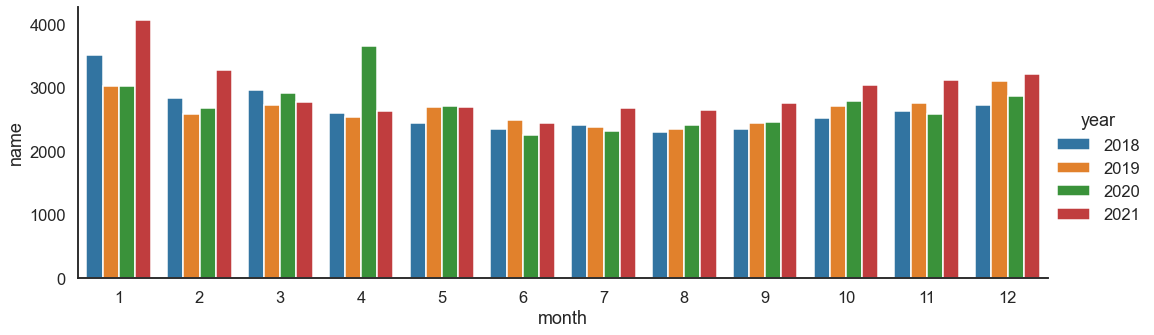

In [34]:
g=df.groupby(['year','month']).agg({'name':np.size}).reset_index()
g = g[(g.year>2017) & (g.year<2022)]
sns.catplot(data=g,x='month',y='name',hue='year',kind='bar',aspect=3.0)

In [8]:
nhomes = pd.read_csv('nursing_homes.csv')
#print (nhomes[:10])

def find_nhome(x):
    for i,r in nhomes.iterrows():
        if r.shortname in x.notice and x.county == r.county:
            return r['name']+','+r.county

x=df[:160]
#x['home'] = x.apply(lambda x: find_nhome(x),1)
#print (x)

In [25]:
pop = pd.read_csv('ireland_population.csv')
wbcdrt = pd.read_csv('ireland_cdrt.csv')

year
2008    27612
2009    27948
2010    27614
2011    25727
2012    26823
2013    27957
2014    28477
2015    29681
2016    30776
2017    30705
2018    31677
2019    31819
2020    32719
2021    35387
2022     2160
dtype: int64


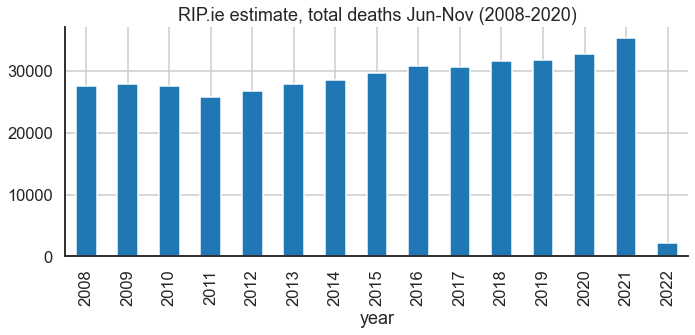

In [35]:
x=df#[(df.month<=12) & (df.month>5)]
totals = x.groupby('year').agg('size')
print (totals)
ax=totals.plot(kind='bar',grid=True,figsize=(10,5))
plt.title('RIP.ie estimate, total deaths Jun-Nov (2008-2020)')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary_v3.png',dpi=120)

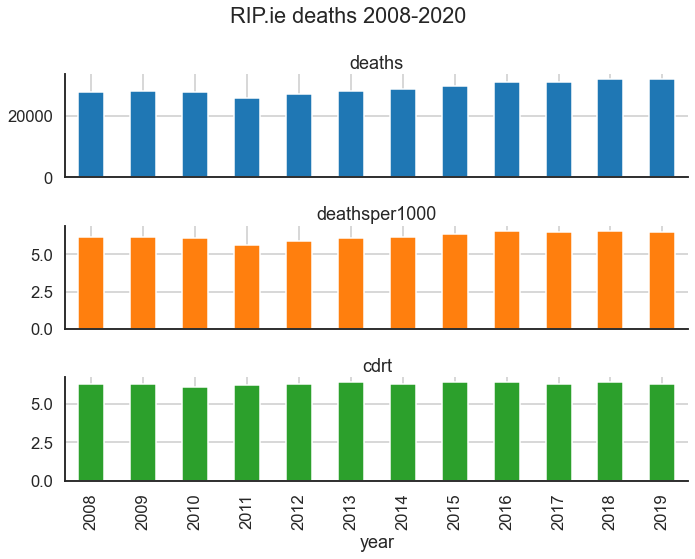

In [72]:
d=pd.DataFrame(totals,columns=['deaths']).reset_index()
d=pop.merge(d,on='year')
d=d.sort_values('year')
d['deathsper1000'] = d.deaths/d['pop']*1e3
d=wbcdrt.merge(d,on='year')
d.plot(x='year',y=['deaths','deathsper1000','cdrt'],kind='bar',subplots=True,grid=True,legend=False,figsize=(10,8))
plt.suptitle('RIP.ie deaths 2008-2020')
sns.despine()
plt.tight_layout()

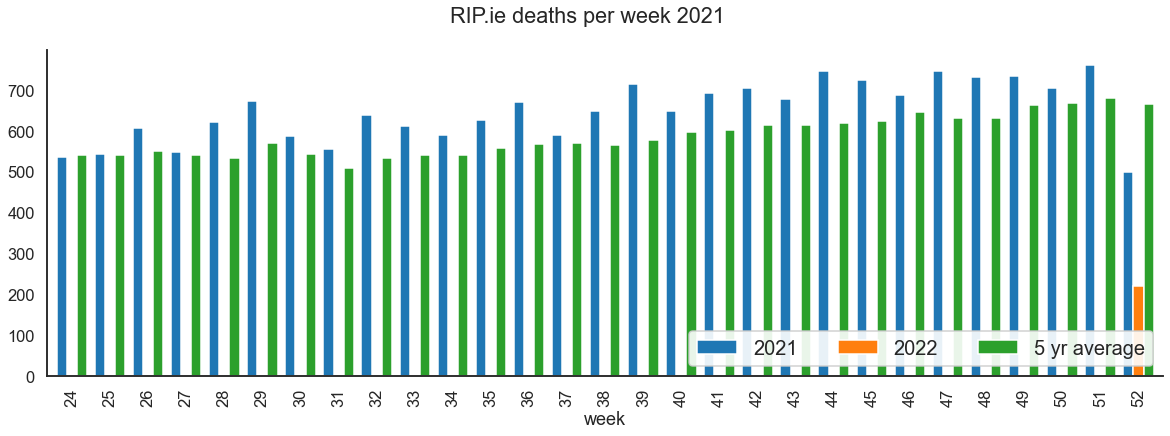

In [37]:
byw = pd.pivot_table(df, index='week',columns='year',values='name',aggfunc='size')
byw['5 yr average'] = byw.iloc[:,8:-1].mean(1)
x=byw.iloc[23:52,13:]
#print (x)
x.plot(kind='bar',width=.8,figsize=(20,6))
#x.T.boxplot(figsize=(18,6))
plt.legend(loc=4,ncol=5,framealpha=0.9,fontsize=20)
plt.suptitle('RIP.ie deaths per week 2021')
sns.despine()
plt.savefig('ireland_deaths_ripie_byweek.png',dpi=150)

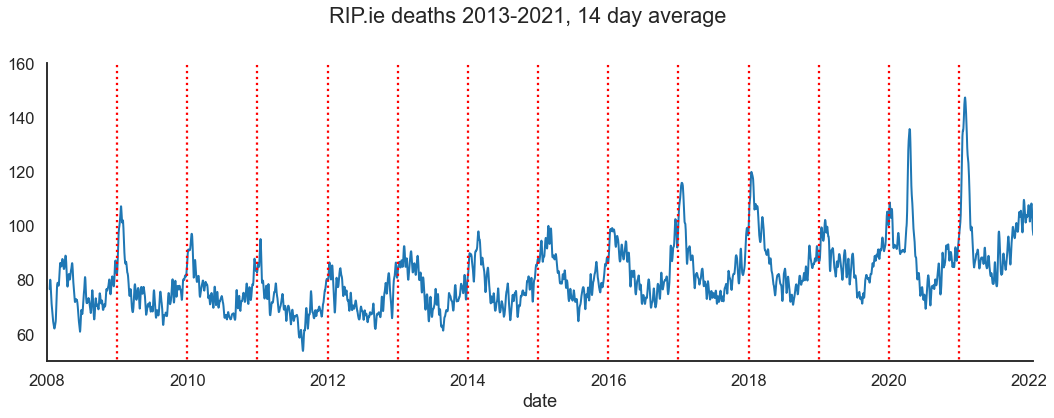

In [38]:
x = df.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=2,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
for y in range(2008,2021):
    ax.vlines(pd.to_datetime('%s-12-31' %y),0,160,color='r',ls=':')

plt.suptitle('RIP.ie deaths 2013-2021, 14 day average')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend_v2.png',dpi=150)

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


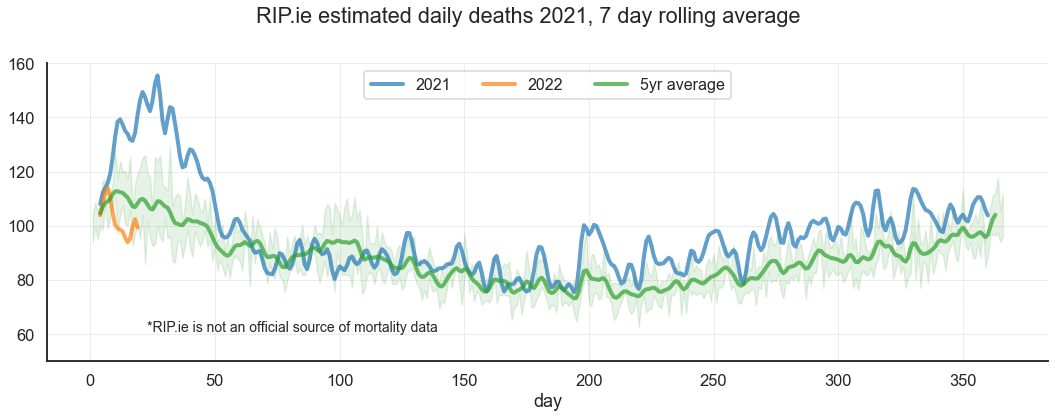

In [76]:
byday = pd.pivot_table(df, index='day',columns='year',values='name',aggfunc='size')
byday['5yr average'] = byday.iloc[:,8:-1].mean(1)
#x = byday.iloc[:,:9]

x = byday[[2021,2022,'5yr average']]
#x = x.loc[50:]
x.loc[364:,2021] = np.nan
win=7
meanday = x.rolling(window=win,win_type='hamming',center=True).mean()
ax=meanday.plot(figsize=(15,6),ylim=(50,160),lw=4,alpha=0.7)
ave=x['5yr average']
sd=byday.iloc[:,8:-1].std(1)

ax.fill_between(ave.index, ave-(sd/2), ave+(sd/2), color='green', alpha=0.1)
ax.grid(linestyle='--',linewidth=.5)
plt.legend(loc=9,ncol=3,fontsize=16)
sns.despine()
plt.suptitle('RIP.ie estimated daily deaths 2021, %s day rolling average' %win)
plt.tight_layout()
plt.text(0.1,0.1,'*RIP.ie is not an official source of mortality data',fontsize=14,transform=ax.transAxes)
plt.savefig('ireland_deaths_ripie_compared_mean_v2.png',dpi=150)

## GRO compare

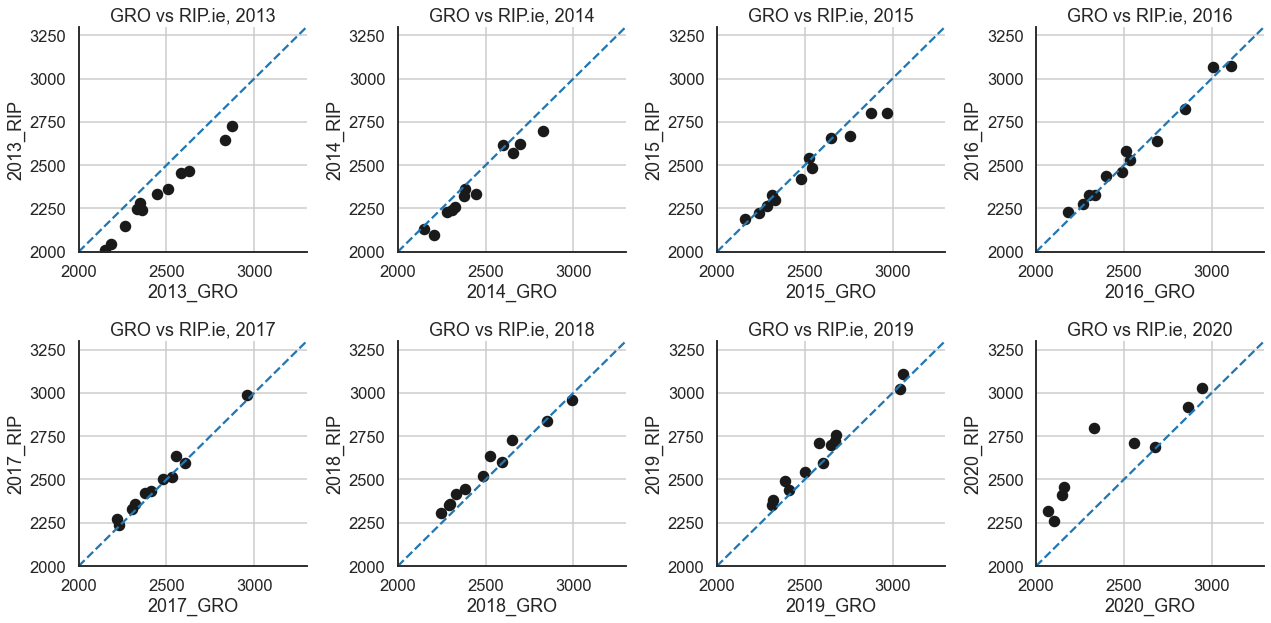

In [40]:
gro = pd.read_csv('gro_deaths.csv')
bymonth = pd.pivot_table(df, index='month',columns='year',values='name',aggfunc='size')
a=bymonth.reset_index()
a.columns=[str(i) for i in a.columns]
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#print (b)
f,axs=plt.subplots(2,4,figsize=(18,9))
axs=axs.flat
i=0
for y in range(2013,2021):
    ax=axs[i]
    b.plot(x='%s_GRO' %y,y='%s_RIP' %y,c='0.1',s=100,kind='scatter',grid=True,ax=ax)
    ax.plot([2000, 3300], [2000, 3300], ls='--')
    ax.set_xlim(2000,3300)
    ax.set_ylim(2000,3300)
    ax.set_title('GRO vs RIP.ie, %s' %y)
    i+=1
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_gro_vs_ripie.png',dpi=150)

## compare eurostat data

In [69]:
eu=pd.read_csv('estat_demo_r_mwk_ts_filtered.tsv',sep='\t').T
eu.columns=['Eurostat']
eu[-30:-10]

,Eurostat
2021-W27,580.0
2021-W28,510.0
2021-W29,600.0
2021-W30,656.0
2021-W31,569.0
2021-W32,537.0
2021-W33,615.0
2021-W34,596.0
2021-W35,578.0
2021-W36,625.0


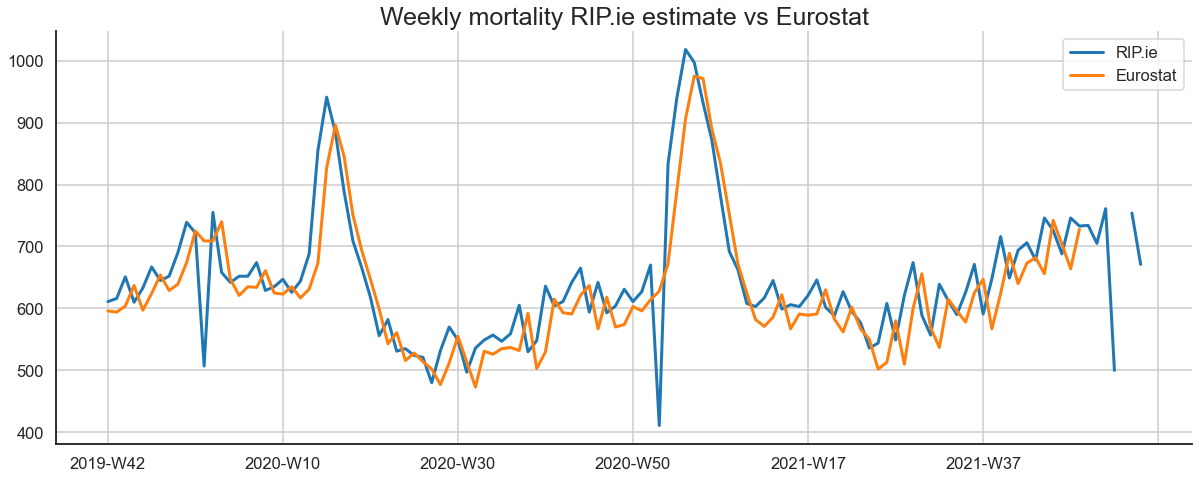

In [71]:
x = df.groupby(['year','week']).size().reset_index()
x['time'] = x.apply(lambda x: '%s-W%02d' %(x.year,x.week),1)
x=x.set_index('time').iloc[:,2:]
x.columns=['RIP.ie']
#print (x[-20:])
x=x.merge(eu,left_index=True, right_index=True,how='right')
#x['diff'] = x.RIP-x.Eurostat
#print (x[-20:])
fig,ax=plt.subplots(1,1,figsize=(17,7))
ax=x.plot(lw=3,ax=ax,grid=True)
sns.despine()
plt.tight_layout()
plt.title('Weekly mortality RIP.ie estimate vs Eurostat',fontsize=25)
#ax2 = fig.add_axes( [0.4, 0.6, 0.15, 0.3])
#x.plot(x='Eurostat',y='RIP.ie',kind='scatter',c='black',ax=ax2)
plt.tight_layout()
fig.savefig('eurostat_ireland_deaths_compared.png')